In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
import pandas as pd
import matplotlib.patches as mpatches

In [2]:
input_image = 'banana.jpg'

Step1: Remove Plates and Stuff

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


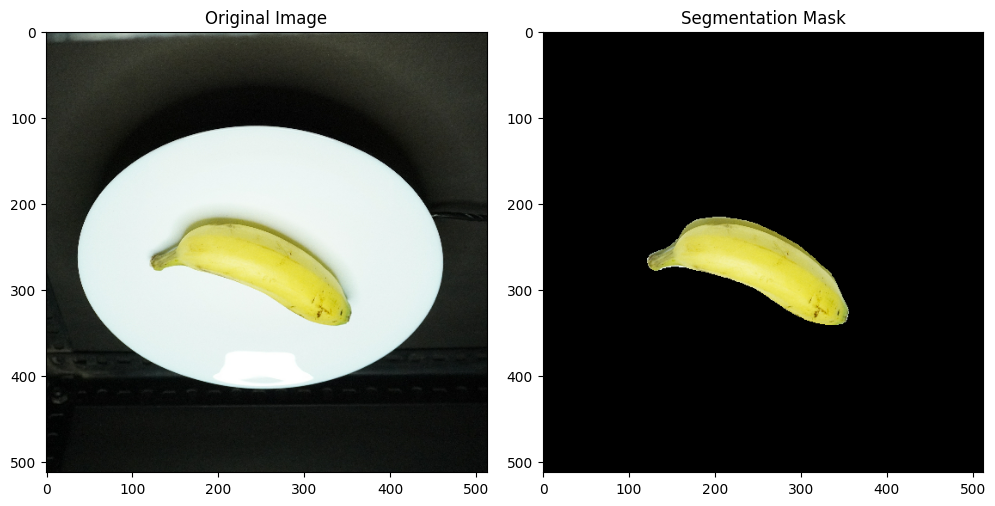

In [19]:


# Extract the tar.gz model
model_filename = 'seefood_segmenter_mobile_food_segmenter_V1_1.tar.gz'
extracted_folder_path = 'extracted_model'

if not os.path.exists(extracted_folder_path):
    with tarfile.open(model_filename, 'r:gz') as tar:
        tar.extractall(path=extracted_folder_path)

# 1. Load the image
# image_path = 'test.jpg'
image_path = input_image
image = tf.image.decode_image(tf.io.read_file(image_path))
image = tf.image.resize(image, [513, 513])
image = image / 255.0  # Normalize to [0, 1]

# Check if the image is 3-channel RGB
if image.shape[-1] != 3:
    print("Make sure your image is RGB.")

# Expand dimensions for batch
image_batch = tf.expand_dims(image, 0)

# 2. Load the local model with specified output keys
m = hub.KerasLayer(extracted_folder_path, signature_outputs_as_dict=True)

# 3. Use the model
results = m(image_batch)

segmentation_probs = results['food_group_segmenter:semantic_probabilities'][0]
segmentation_mask = results['food_group_segmenter:semantic_predictions'][0]

# Define the label classes to remove (adjust as needed)
classes_to_remove = [0, 23, 24]  # Example: Remove classes 2, 4, and 6

# Create a mask to remove the specified classes
mask_to_remove = np.isin(segmentation_mask, classes_to_remove)

# Apply the mask to remove the corresponding regions from the original image
image_without_classes = image * (1 - mask_to_remove[..., tf.newaxis])  # Set to black (or any desired background color)

# Save the modified image without specified classes
output_image_path = 'modified_image.jpg'  # Specify the desired output path and filename
tf.keras.preprocessing.image.save_img(output_image_path, image_without_classes.numpy())  # Save the modified image


# 4. Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(image_without_classes.numpy())
plt.title('Segmentation Mask')

# plt.subplot(1, 3, 3)
# # Overlay the segmentation mask on the original image
# class_id = 5
# overlay = np.where(segmentation_mask == class_id, 1, 0)
# plt.imshow(image)
# plt.imshow(overlay, alpha=0.5)
# plt.title(f'Overlay (for class {class_id})')

plt.tight_layout()
plt.show()




Monocular Depth Estimation

In [ ]:
from PIL import Image
import numpy as np
import requests
import torch
import sys

from transformers import DPTForDepthEstimation, DPTFeatureExtractor

torch.device('cpu')

model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=False)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

if sys.argv[1] == '':
    image = Image.open('food.jpg')
else:
    image = Image.open(str(sys.argv[1]))

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
print(output)
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth.show()

depth.save("output.png")

In [1]:
!pip install pyntcloud

     ---------------------------------------- 0.0/346.3 kB ? eta -:--:--
     - -------------------------------------- 10.2/346.3 kB ? eta -:--:--
     ---- -------------------------------- 41.0/346.3 kB 653.6 kB/s eta 0:00:01
     -------- ---------------------------- 81.9/346.3 kB 512.0 kB/s eta 0:00:01
     -------- ---------------------------- 81.9/346.3 kB 512.0 kB/s eta 0:00:01
     -------------- --------------------- 143.4/346.3 kB 655.8 kB/s eta 0:00:01
     -------------------- --------------- 194.6/346.3 kB 695.5 kB/s eta 0:00:01
     --------------------- -------------- 204.8/346.3 kB 655.1 kB/s eta 0:00:01
     ---------------------------- ------- 276.5/346.3 kB 774.0 kB/s eta 0:00:01
     ------------------------------- ---- 307.2/346.3 kB 731.4 kB/s eta 0:00:01
     ------------------------------------ 346.3/346.3 kB 716.6 kB/s eta 0:00:00


In [4]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/fb/c4/f574ba6f04e6d7bf8c38d23e7a52389566dd7631fee0bcdd79ea07ef2dbf/opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.1 MB 2.3 MB/s eta 0:00:17
   ---------------------------------------- 0.2/38.1 MB 2.4 MB/s eta 0:00:17
   ---------------------------------------- 0.2/38.1 MB 2.2 MB/s eta 0:00:18
   ---------------------------------------- 0.2/38.1 MB 2.2 MB/s eta 0:00:18
   ---------------------------------------- 0.3/38.1 MB 1.2 MB/s eta 0:00:32
   ---------------------------------------- 0.3/38.1 MB 1.2 MB/s eta 0:00:32
   ---------------------------------------- 0.5/38.1 MB 1.3 MB/s eta 0:00:29
   ---------------------------------------- 0.5/38.1 MB 1.3 MB/s eta 0:00:29
    --------------------------------------- 0.6/38.1 MB 1.5 MB/s eta 0:00:25
    ------------

In [14]:
!pip install pyntcloud scipy numpy-stl


In [19]:
import numpy as np
import pyntcloud
import tensorflow as tf
from pyntcloud import PyntCloud
import cv2
import pandas as pd
from scipy.spatial import ConvexHull


# Load the segmented depth image as a NumPy array
image_path = "MDE_Masked.jpg"
image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
segmented_depth_image = image

# Extract depth values within the segmented food region
depth_values = segmented_depth_image[segmented_depth_image > 0]

# Assuming pixel coordinates represent (x, y) and depth represents z,
# create a 3D point cloud
height, width = segmented_depth_image.shape
y_coords, x_coords = np.where(segmented_depth_image > 0)
point_cloud = np.column_stack((x_coords, y_coords, depth_values))

# Create a PyntCloud object from the point cloud
cloud = PyntCloud(points=pd.DataFrame(point_cloud, columns=["x", "y", "z"]))

# Compute the convex hull of the 3D point cloud
hull = ConvexHull(cloud.points.values)

# Create a mesh from the convex hull
mesh = numpy_stl.mesh.Mesh(np.column_stack(hull.points[hull.vertices]))

# Calculate the volume of the mesh
volume = mesh.get_mass_properties()[0]

# Print the estimated volume
print(f"Estimated volume of food: {volume} cubic units")



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices